<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/LEAR_Easy_recalibration_Bridging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Total Emissions in Scenario 1 (Normal Charging): 322.22 kg CO2
Total Emissions in Scenario 2 (Smart Charging): 209.08 kg CO2
Potential Emissions Savings: 113.14 kg CO2
Cumulative Emissions for E1 (Normal Charging) at the end of the year: 322.22 kg CO2
Cumulative Emissions for E2 (Smart Charging) at the end of the year: 209.08 kg CO2


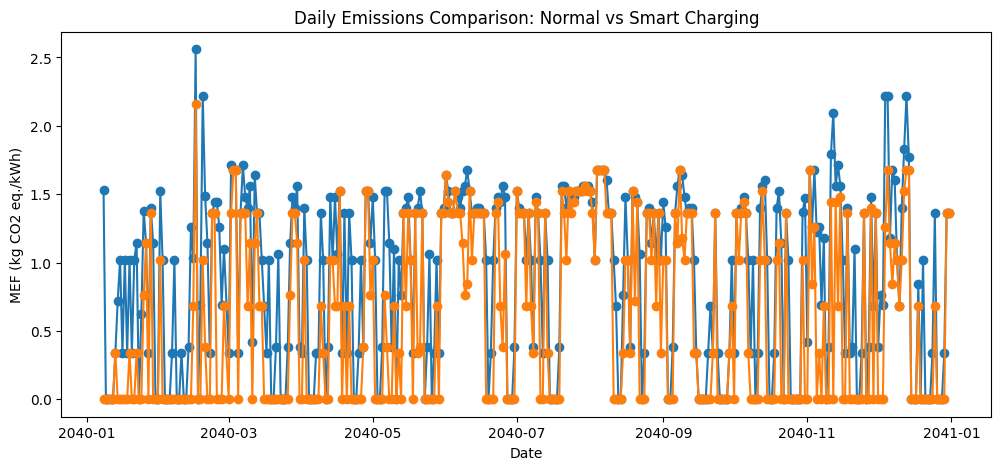

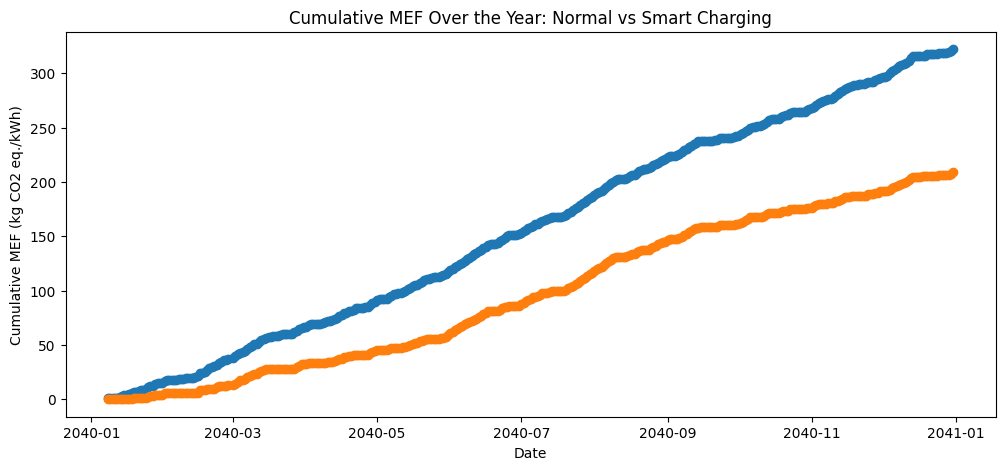

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Load the data from the Excel file
file_path = '/Users/vaughan/Desktop/MEF_2040charging.xlsx'
df = pd.read_excel(file_path)

# Convert the 'Date' column to datetime format
df['datetime'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')

# Sort the data by datetime just in case
df = df.sort_values('datetime').reset_index(drop=True)

# Add a 'date' column to group by day and an 'hour' column to filter by hour
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour

# Define the column name for the MEF data
mef_column = 'MEF--ESM'

# Define the charging period
start_hour = 20
end_hour = 6
charging_hours = 4

# Function to calculate E1 (Normal Charging)
def calculate_E1(df):
    E1_list = []
    for date, group in df.groupby('date'):
        # Filter hours between 20:00 and 06:00
        night_hours = group[(group['hour'] >= start_hour) | (group['hour'] < end_hour)]
        # Sum the first 4 hours of MEF for each day (normal charging)
        E1 = night_hours[mef_column].iloc[:charging_hours].sum()
        E1_list.append(E1)
    return np.array(E1_list)

# Function to calculate E2 (Smart Charging with non-consecutive hours)
def calculate_E2(df):
    E2_list = []
    for date, group in df.groupby('date'):
        # Filter hours between 20:00 and 06:00
        night_hours = group[(group['hour'] >= start_hour) | (group['hour'] < end_hour)]
        # If there are fewer than 4 hours available, skip this day
        if len(night_hours) < charging_hours:
            E2_list.append(np.nan)
            continue
        
        # Get MEF values for the available hours
        mef_values = night_hours[mef_column].values
        
        # Calculate all possible combinations of 4 hours (non-consecutive)
        hour_combinations = combinations(range(len(mef_values)), charging_hours)
        
        # Compute the total MEF for each combination of 4 hours and find the minimum
        min_emissions = np.inf
        for combo in hour_combinations:
            total_emissions = sum(mef_values[i] for i in combo)
            if total_emissions < min_emissions:
                min_emissions = total_emissions
                
        E2_list.append(min_emissions)
    return np.array(E2_list)

# Calculate E1 and E2 for each day
E1 = calculate_E1(df)
E2 = calculate_E2(df)

# Aggregate emissions over the entire year
total_E1 = np.nansum(E1)  # Use nansum to ignore any NaN values
total_E2 = np.nansum(E2)  # Use nansum to ignore any NaN values

# Calculate cumulative emissions
cumulative_E1 = np.nancumsum(E1)
cumulative_E2 = np.nancumsum(E2)

# Print the results
print(f'Total Emissions in Scenario 1 (Normal Charging): {total_E1:.2f} kg CO2')
print(f'Total Emissions in Scenario 2 (Smart Charging): {total_E2:.2f} kg CO2')
print(f'Potential Emissions Savings: {total_E1 - total_E2:.2f} kg CO2')

# Print the cumulative emissions at the end of the year
print(f'Cumulative Emissions for E1 (Normal Charging) at the end of the year: {cumulative_E1[-1]:.2f} kg CO2')
print(f'Cumulative Emissions for E2 (Smart Charging) at the end of the year: {cumulative_E2[-1]:.2f} kg CO2')

# Plot the daily comparison (without labels)
plt.figure(figsize=(12, 5))
plt.plot(df['date'].unique(), E1, marker='o')
plt.plot(df['date'].unique(), E2, marker='o')
plt.xlabel('Date')
plt.ylabel('MEF (kg CO2 eq./kWh)')
plt.title('Daily Emissions Comparison: Normal vs Smart Charging')
plt.show()

# Plot cumulative emissions over the year (without labels)
plt.figure(figsize=(12, 5))
plt.plot(df['date'].unique(), cumulative_E1, marker='o')
plt.plot(df['date'].unique(), cumulative_E2, marker='o')
plt.xlabel('Date')
plt.ylabel('Cumulative MEF (kg CO2 eq./kWh)')
plt.title('Cumulative MEF Over the Year: Normal vs Smart Charging')
plt.show()
